# Introduction

In this lab, we will learn how to perform model selection with Gaussian Mixture Models (GMM) using information-theory criteria. Model selection concerns both the covariance type and the number of components in the model. We will use the Akaike Information Criterion (AIC) and the Bayes Information Criterion (BIC) to select the best model. We will generate two components by randomly sampling the standard normal distribution. One component is kept spherical yet shifted and re-scaled. The other one is deformed to have a more general covariance matrix.

# Data Generation

We generate two components (each one containing **n_samples**) by randomly sampling the standard normal distribution as returned by **numpy.random.randn**. One component is kept spherical yet shifted and re-scaled. The other one is deformed to have a more general covariance matrix.

In [1]:
import numpy as np

n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

# Visualization

We can visualize the different components using Matplotlib.

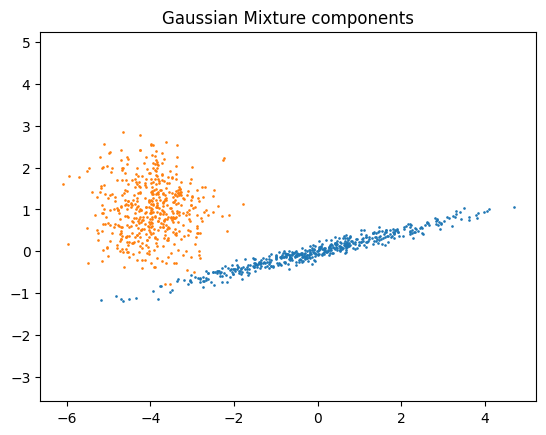

In [2]:
import matplotlib.pyplot as plt

plt.scatter(component_1[:, 0], component_1[:, 1], s=0.8)
plt.scatter(component_2[:, 0], component_2[:, 1], s=0.8)
plt.title("Gaussian Mixture components")
plt.axis("equal")
plt.show()

# Model Training and Selection

We vary the number of components from 1 to 6 and the type of covariance parameters to use:

- "full": each component has its own general covariance matrix.
- "tied": all components share the same general covariance matrix.
- "diag": each component has its own diagonal covariance matrix.
- "spherical": each component has its own single variance.

We score the different models and keep the best model (the lowest BIC). This is done by using GridSearchCV and a user-defined score function which returns the negative BIC score. The best set of parameters and estimator are stored in best_parameters_ and best_estimator_, respectively.

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x14b8487c0>)

# Plot the BIC Scores

We create a **pandas.DataFrame* from the results of the cross-validation done by the grid search. We re-inverse the sign of the BIC score to show the effect of minimizing it. We use **seaborn** to plot the BIC scores.

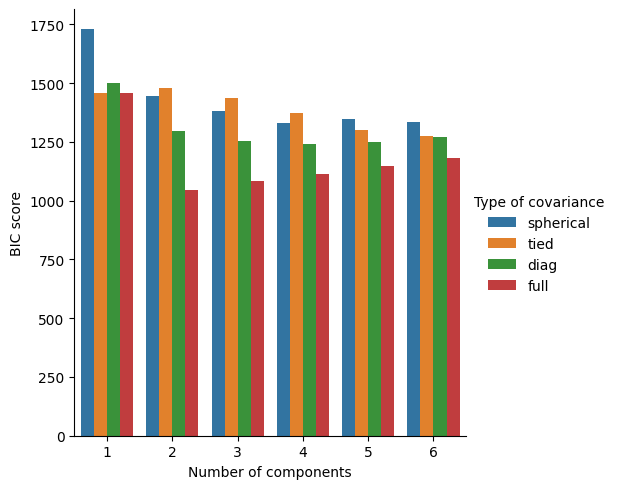

In [4]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

# Plot the Best Model

We plot an ellipse to show each Gaussian component of the selected model. For such purpose, one needs to find the eigenvalues of the covariance matrices as returned by the covariances_ attribute. The shape of such matrices depends on the covariance_type:

- "full": (n_components, n_features, n_features)
- "tied": (n_features, n_features)
- "diag": (n_components, n_features)
- "spherical": (n_components,)

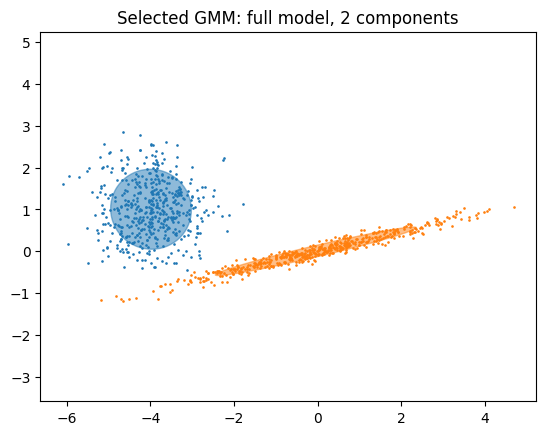

In [5]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

# Summary

In this lab, we learned how to perform model selection with Gaussian Mixture Models (GMM) using information-theory criteria. We used the Akaike Information Criterion (AIC) and the Bayes Information Criterion (BIC) to select the best model. We generated two components by randomly sampling the standard normal distribution. One component was kept spherical yet shifted and re-scaled. The other one was deformed to have a more general covariance matrix. We visualized the different components, trained and selected the best model, plotted the BIC scores, and plotted the best model.